# Generating Supplementary figure 3

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import numpy as np
import pyranges as pr
import pybedtools as pbt
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

import random

random.seed(42)

np.random.seed(42)

## Importing files

In [11]:
def intersect_bed(df1, df2, invert=False, how="containment"):
    gr1, gr2 = pr.PyRanges(df1), pr.PyRanges(df2)
    gr = gr1.intersect(gr2, invert=invert, nb_cpu=6, how=how)
    return gr.df.drop_duplicates()


genes_from_annotation = pr.read_gtf("../../mus_musculus/Mus_musculus.GRCm38.96.gtf").df
genes_from_annotation = genes_from_annotation[["gene_id", "Chromosome", "Strand", "Start", "End", "gene_name"]]
genes_from_annotation.columns = ["id", "chr", "strand", "start", "end", "name"]
genes_from_annotation["chr"] = np.array(["chr"] * len(genes_from_annotation["chr"])) + np.array(genes_from_annotation["chr"].astype(str))

# filtering out unwanted and incomplete chromosomes
genes_from_annotation = genes_from_annotation[[len(chromosome) < 6 for chromosome in genes_from_annotation['chr']]]
genes_from_annotation = genes_from_annotation[[chromosome != "chrMT" for chromosome in genes_from_annotation['chr']]]

# Importing ZGA genes
ZGA_genes_list = pd.read_csv('../../pan_ZGA_lists/Pan_1_degree_ZGA_genes.csv')["Gene_id"].str.upper()


# Adjusting annotation and creating ZGA and non-ZGA data frames
window_before_TSS = 8000
Non_ZGA_genes_from_annotation = genes_from_annotation[~genes_from_annotation["name"].str.upper().isin(ZGA_genes_list)]
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation.drop_duplicates(subset='name', keep='first')
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation[["chr", "start", "end", "strand", "name"]]
start = [x - window_before_TSS if z == "+" else y for x, y, z in zip(Non_ZGA_genes_from_annotation["start"], Non_ZGA_genes_from_annotation["end"], Non_ZGA_genes_from_annotation["strand"])]
end = [x if z == "+" else y + window_before_TSS for x, y, z in zip(Non_ZGA_genes_from_annotation["start"], Non_ZGA_genes_from_annotation["end"], Non_ZGA_genes_from_annotation["strand"])]
Non_ZGA_genes_from_annotation["start"] = start
Non_ZGA_genes_from_annotation["end"] = end
Non_ZGA_genes_from_annotation.columns = [0,1,2,3,4]
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation[[0,1,2,4]]
Non_ZGA_genes_from_annotation.columns = ["Chromosome", "Start", "End", "name"]
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation.sample(frac = 1)

ZGA_genes_from_annotation = genes_from_annotation[genes_from_annotation["name"].str.upper().isin(ZGA_genes_list)]
ZGA_genes_from_annotation = ZGA_genes_from_annotation.drop_duplicates(subset='name', keep='first')
ZGA_genes_from_annotation = ZGA_genes_from_annotation[["chr", "start", "end", "strand", "name"]]
start = [x - window_before_TSS if z == "+" else y for x, y, z in zip(ZGA_genes_from_annotation["start"], ZGA_genes_from_annotation["end"], ZGA_genes_from_annotation["strand"])]
end = [x if z == "+" else y + window_before_TSS for x, y, z in zip(ZGA_genes_from_annotation["start"], ZGA_genes_from_annotation["end"], ZGA_genes_from_annotation["strand"])]
ZGA_genes_from_annotation["start"] = start
ZGA_genes_from_annotation["end"] = end
ZGA_genes_from_annotation.columns = [0,1,2,3,4]
ZGA_genes_from_annotation = ZGA_genes_from_annotation[[0,1,2,4]]
ZGA_genes_from_annotation.columns = ["Chromosome", "Start", "End", "name"]
ZGA_genes_from_annotation = ZGA_genes_from_annotation.sample(frac = 1)


In [12]:
all_genes_from_annotation = pd.concat([ZGA_genes_from_annotation, Non_ZGA_genes_from_annotation]) #[["Chromosome", "Start", "End"]]
all_genes_from_annotation.Start = [int(x) for x in all_genes_from_annotation.Start]
all_genes_from_annotation.End = [int(x) for x in all_genes_from_annotation.End]
all_genes_from_annotation["name"] = ["ZGA" if x else "non-ZGA" for x in all_genes_from_annotation["name"].str.upper().isin(ZGA_genes_from_annotation.name.str.upper())]

In [19]:
# Please assemble the complete ATAC-seq file before starting the analysis

In [13]:
condition_2C = "./ATAC_seq_2cell_DMSO_merged_rep1_rep2_from_Gassler_et_al_Science_2022.bedgraph"
condition_2c_raw = pd.read_csv(condition_2C, header=None, sep="\t",index_col=None) 
condition_2c_raw.columns = ["Chromosome", "Start", "End", 3]
condition_2c_raw_G_pbt = pbt.BedTool.from_dataframe(condition_2c_raw)

In [14]:
df_intersect_omniATAC_2cell = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_annotation), condition_2c_raw_G_pbt, loj=True).to_dataframe()
df_intersect_omniATAC_2cell["thickStart"].replace('.',np.nan, inplace=True)
df_intersect_omniATAC_2cell = df_intersect_omniATAC_2cell.dropna()
df_intersect_omniATAC_2cell["thickStart"] = df_intersect_omniATAC_2cell["thickStart"].apply(pd.to_numeric)
df_intersect_omniATAC_2cell = df_intersect_omniATAC_2cell.groupby(['chrom', 'start', 'end', 'name']).agg({'thickStart': np.sum}).reset_index()

/opt/miniconda3/envs/py37/lib/python3.8/site-packages/pybedtools/bedtool.py:3714: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pandas.read_csv(self.fn, *args, sep="\t", **kwargs)


In [15]:
data = pd.read_csv('../../mm10_repeatmasker.csv',sep="\t", header=None)
data.columns = ['#bin', 'swScore', 'milliDiv', 'milliDel', 'milliIns', 'genoName',
       'genoStart', 'genoEnd', 'genoLeft', 'strand', 'repName', 'repClass',
       'repFamily', 'repStart', 'repEnd', 'repLeft', 'id']

mm10_repeatmasker = data[["genoName","genoStart","genoEnd","strand","repName","repClass","repFamily"]]
mm10_repeatmasker = mm10_repeatmasker.drop_duplicates()
mm10_repeatmasker = mm10_repeatmasker[[True if len(x)<6 else False for x in list(mm10_repeatmasker["genoName"])]]
mm10_repeatmasker

,genoName,genoStart,genoEnd,strand,repName,repClass,repFamily
0,chr1,3000000,3002128,-,L1_Mus3,LINE,L1
1,chr1,3003152,3003994,-,L1Md_F,LINE,L1
2,chr1,3003993,3004054,-,L1_Mus3,LINE,L1
3,chr1,3004040,3004206,+,L1_Rod,LINE,L1
4,chr1,3004206,3004270,+,(CAAA)n,Simple_repeat,Simple_repeat
...,...,...,...,...,...,...,...
5146451,chrY,90838012,90838289,-,L1MA7,LINE,L1
5146452,chrY,90838299,90838481,-,MLT1E2,LTR,ERVL-MaLR
5146453,chrY,90838554,90838722,-,MLT1E2,LTR,ERVL-MaLR
5146454,chrY,90843304,90843490,+,MER58A,DNA,hAT-Charlie


## Accessibility vs RE number. Panel A

Alu
Slope: [0.73938338]
Intercept: 0.08862057229645301
Root mean squared error:  0.024670056475470804
R2 score:  0.27098666034578356
B2
Slope: [0.49673303]
Intercept: 0.09111899278490271
Root mean squared error:  0.02587008747296059
R2 score:  0.1345629701440968
L1
Slope: [-0.40376937]
Intercept: 0.21860484578262868
Root mean squared error:  0.034944831052911005
R2 score:  0.07104646891435284
[<matplotlib.collections.PathCollection object at 0x2fd5cdc40>, <matplotlib.collections.PathCollection object at 0x2b55fae20>]
ERVL
Slope: [0.08120818]
Intercept: 0.05214780582803385
Root mean squared error:  0.015243034891206623
R2 score:  0.007037590959933504
ERVK
Slope: [-0.05091906]
Intercept: 0.06879157125706373
Root mean squared error:  0.010949005097928587
R2 score:  0.003865962424000391
ERV1
Slope: [0.00615312]
Intercept: 0.04378714497132599
Root mean squared error:  0.014911146229011539
R2 score:  4.161301133498441e-05
[<matplotlib.collections.PathCollection object at 0x2fede0a90>, <matpl

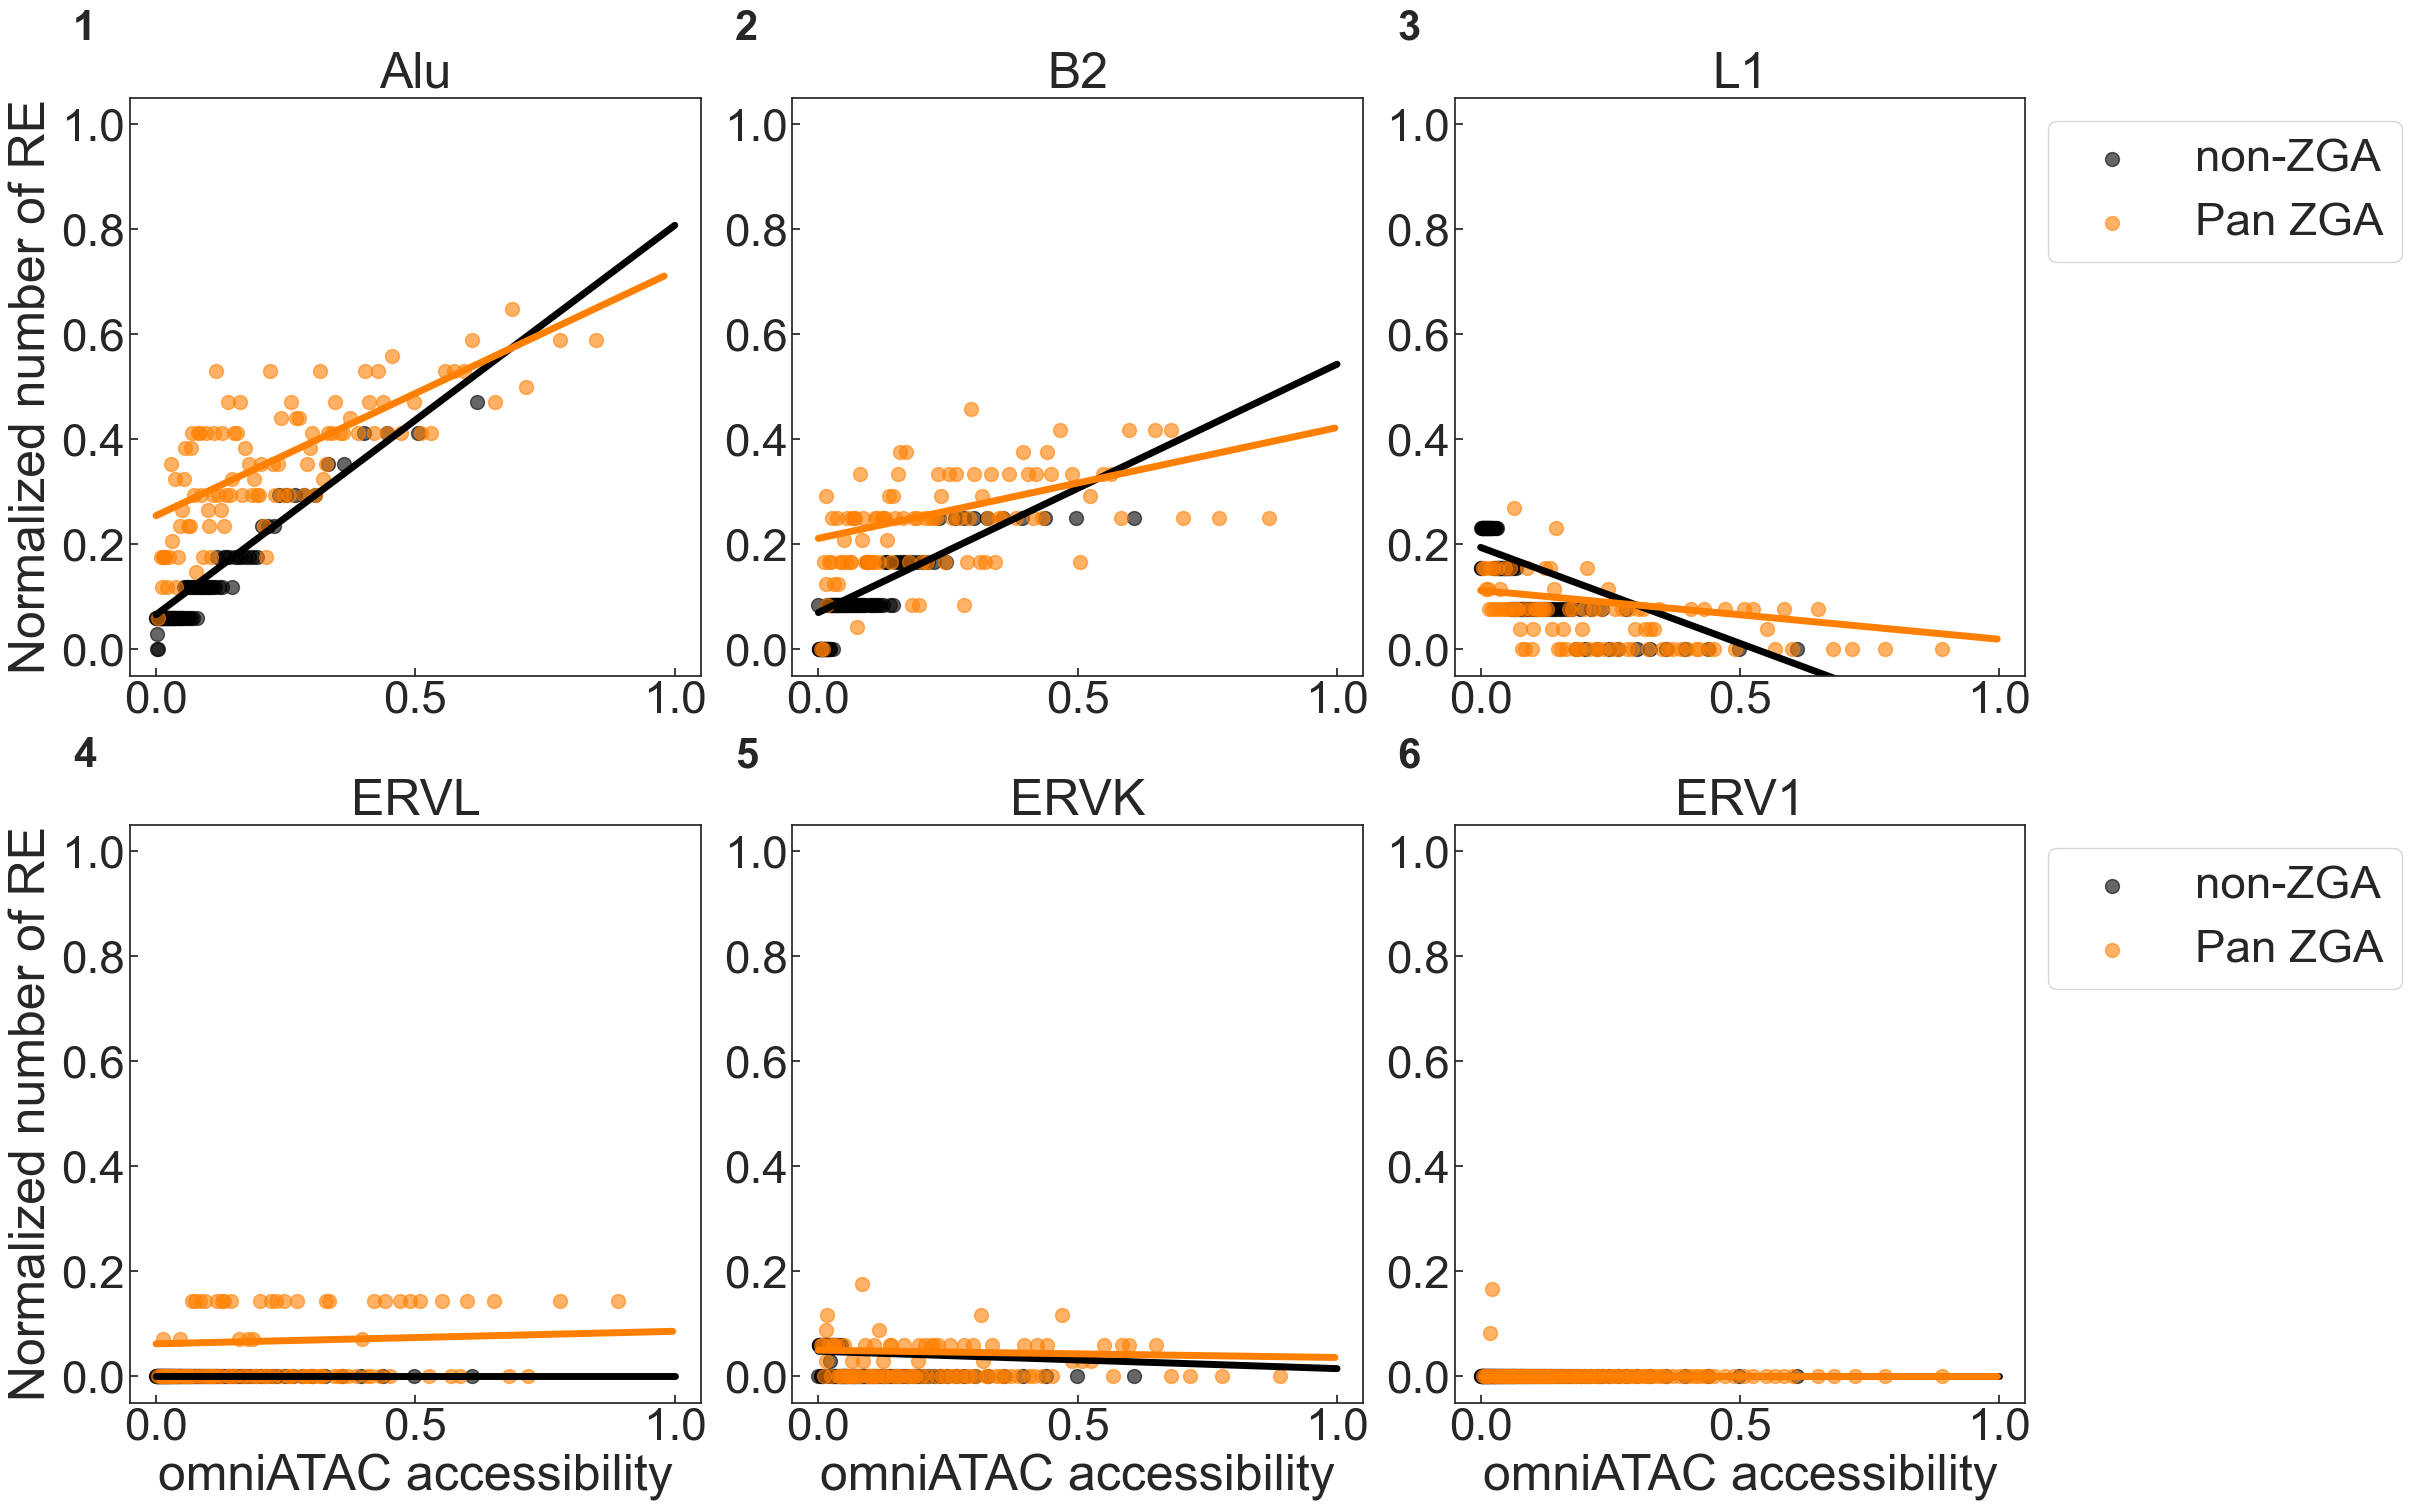

In [16]:
sns.set(font_scale=3, style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
matplotlib.rcParams['font.weight'] = "medium"
matplotlib.rcParams['axes.labelweight'] = 'medium'
matplotlib.rcParams['figure.titleweight'] = 'medium'
matplotlib.rcParams['axes.titleweight'] = 'medium'
matplotlib.rcParams['figure.figsize'] = 24, 15
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

f = plt.figure(constrained_layout=True)
gs = f.add_gridspec(2, 3)

i = 0
j = 0
c = 0


for region_name in ["Alu", "B2", "L1", "ERVL", "ERVK", "ERV1"]:

    print(region_name)

    header = f"{region_name}"

    mm10_hc_rep_tmp = mm10_repeatmasker[mm10_repeatmasker["repFamily"]==region_name]
    mm10_hc_rep_tmp = mm10_hc_rep_tmp[["genoName","genoStart","genoEnd"]]
    mm10_hc_rep_tmp = pbt.BedTool.from_dataframe(mm10_hc_rep_tmp)

    new_df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(df_intersect_omniATAC_2cell), mm10_hc_rep_tmp, c=True).to_dataframe()

    new_df["thickStart_y"] = new_df["strand"]/ mm10_repeatmasker[mm10_repeatmasker["repFamily"]==region_name].shape[0]
    new_df["thickStart_x"] = new_df["score"]

    new_df = new_df[new_df["thickStart_y"] < np.percentile(new_df["thickStart_y"], 99.9)]
    new_df = new_df[new_df["thickStart_x"] < np.percentile(new_df["thickStart_x"], 99.9)]

    
    new_df["thickStart_y"] = (new_df["thickStart_y"]-min(new_df["thickStart_y"]))/(max(new_df["thickStart_y"])-min(new_df["thickStart_y"]))
    new_df["thickStart_x"] = (new_df["thickStart_x"]-min(new_df["thickStart_x"]))/(max(new_df["thickStart_x"])-min(new_df["thickStart_x"]))

    y  = new_df["thickStart_y"]
    x  = new_df["thickStart_x"]



    #sns.scatterplot(data=new_df, x="thickStart_x", y="thickStart_y")
    window = int(round(len(x)*0.001, 1))
    window = len(x)//100 + 1

    dfq = pd.DataFrame({"x":np.array(x), "y":np.array(y)})
    dfq = dfq.sort_values("x")
    dfq = dfq.dropna()
    #dfq = dfq[dfq["x"] < 100]

    x = np.array([dfq["x"]]).reshape(-1, 1)
    y = np.array(dfq["y"])

    # sckit-learn implementation

    # Model initialization
    regression_model = LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(x, y)
    # Predict
    y_predicted = regression_model.predict(x)

    # model evaluation
    rmse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y, y_predicted)

    # printing values
    print('Slope:' ,regression_model.coef_)
    sr = stats.spearmanr(x, y)
    if regression_model.coef_ >= 0:
        sr = sr
    else:
        sr = sr

    print('Intercept:', regression_model.intercept_)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    
    if c == 0:
        ax = f.add_subplot(gs[j,i])
    else:
        ax = f.add_subplot(gs[j,i], sharex=ax, sharey=ax)


    sns.regplot(data=new_df[new_df["name"] == "non-ZGA"],x="thickStart_x", y="thickStart_y", x_estimator=np.median, n_boot=100, robust=True, 
                scatter_kws={"color": "black", "alpha":0.6, "s": 100}, 
                line_kws={"color": "black", 'linewidth':5}, 
                ci = None, x_ci='ci',x_bins=100, label=["non-ZGA","ZGA"])

    sns.regplot(data=new_df[new_df["name"] == "ZGA"],x="thickStart_x", y="thickStart_y", x_estimator=np.median, n_boot=100, robust=True, 
                scatter_kws={"color": '#ff7f00', "alpha":0.6, "s": 100}, 
                line_kws={"color": '#ff7f00', 'linewidth':5}, 
                ci = None, x_ci='ci',x_bins=100, label=["non-ZGA","ZGA"])

    plt.title(header)
    plt.xlabel('')
    if j == 1:
        plt.xlabel('omniATAC accessibility')
    plt.ylabel('')
    if i == 0:
        plt.ylabel('Normalized number of RE')

    plt.ylim(-0.05,1.05)
    plt.xlim(-0.05,1.05)
    
    
    ax.text(-0.1, 1.1, c+1, transform=ax.transAxes, size=30, weight='bold')
    
    i += 1
    c += 1
    

    if c%3 == 0:
        handles, labels = ax.get_legend_handles_labels()
        print(handles)
        plt.legend(handles=handles, labels=["non-ZGA","Pan ZGA"], loc = 2, bbox_to_anchor = (1,1))
        j += 1
        i = 0

plt.show()

f.savefig("./Panel_A.pdf") 

## Expression vs RE number. Panel B

In [17]:
data = pd.read_csv("./RNA_seq_DEgenes_G2_2cell-vs-G2_zygote_from_Gassler_et_al_Science_2022.csv", sep=";") 
data["external_gene_name"] = data["gene_id"].str.upper()
Expression = data

all_genes_from_UCSC_manual1 = pd.concat([Non_ZGA_genes_from_annotation,ZGA_genes_from_annotation])  # [["Chromosome","begin","end", "name"]]
RE_df=pd.DataFrame()
Alu = mm10_repeatmasker[mm10_repeatmasker["repFamily"] == "Alu"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "B1"
RE_df = RE_df.append(df)

Alu = mm10_repeatmasker[mm10_repeatmasker["repFamily"] == "B2"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "B2"
RE_df = RE_df.append(df)

Alu = mm10_repeatmasker[mm10_repeatmasker["repFamily"] == "L1"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "L1"
RE_df = RE_df.append(df)


Alu = mm10_repeatmasker[mm10_repeatmasker["repFamily"] == "ERVL"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "ERVL"
RE_df = RE_df.append(df)

Alu = mm10_repeatmasker[mm10_repeatmasker["repFamily"] == "ERVK"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "ERVK"
RE_df = RE_df.append(df)

Alu = mm10_repeatmasker[mm10_repeatmasker["repFamily"] == "ERV1"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "ERV1"
RE_df = RE_df.append(df)




RE_df_Expression = pd.merge(RE_df,Expression,on='external_gene_name')

RE_df_Expression["G2/2C log2FoldChange"] = RE_df_Expression["log2FoldChange"]

TF = "B1"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")
TF = "B2"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")
TF = "L1"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")

TF = "ERVL"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")

TF = "ERVK"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")

TF = "ERV1"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")



/var/folders/fz/qb92b10d6d18gb2mcr1t_ls80000gq/T/ipykernel_47208/3633631851.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RE_df = RE_df.append(df)
/var/folders/fz/qb92b10d6d18gb2mcr1t_ls80000gq/T/ipykernel_47208/3633631851.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RE_df = RE_df.append(df)
/var/folders/fz/qb92b10d6d18gb2mcr1t_ls80000gq/T/ipykernel_47208/3633631851.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RE_df = RE_df.append(df)
/var/folders/fz/qb92b10d6d18gb2mcr1t_ls80000gq/T/ipykernel_47208/3633631851.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RE_df = RE_df.append(df)
/var/folders/fz/qb92b10d6d18

<Figure size 800x600 with 0 Axes>

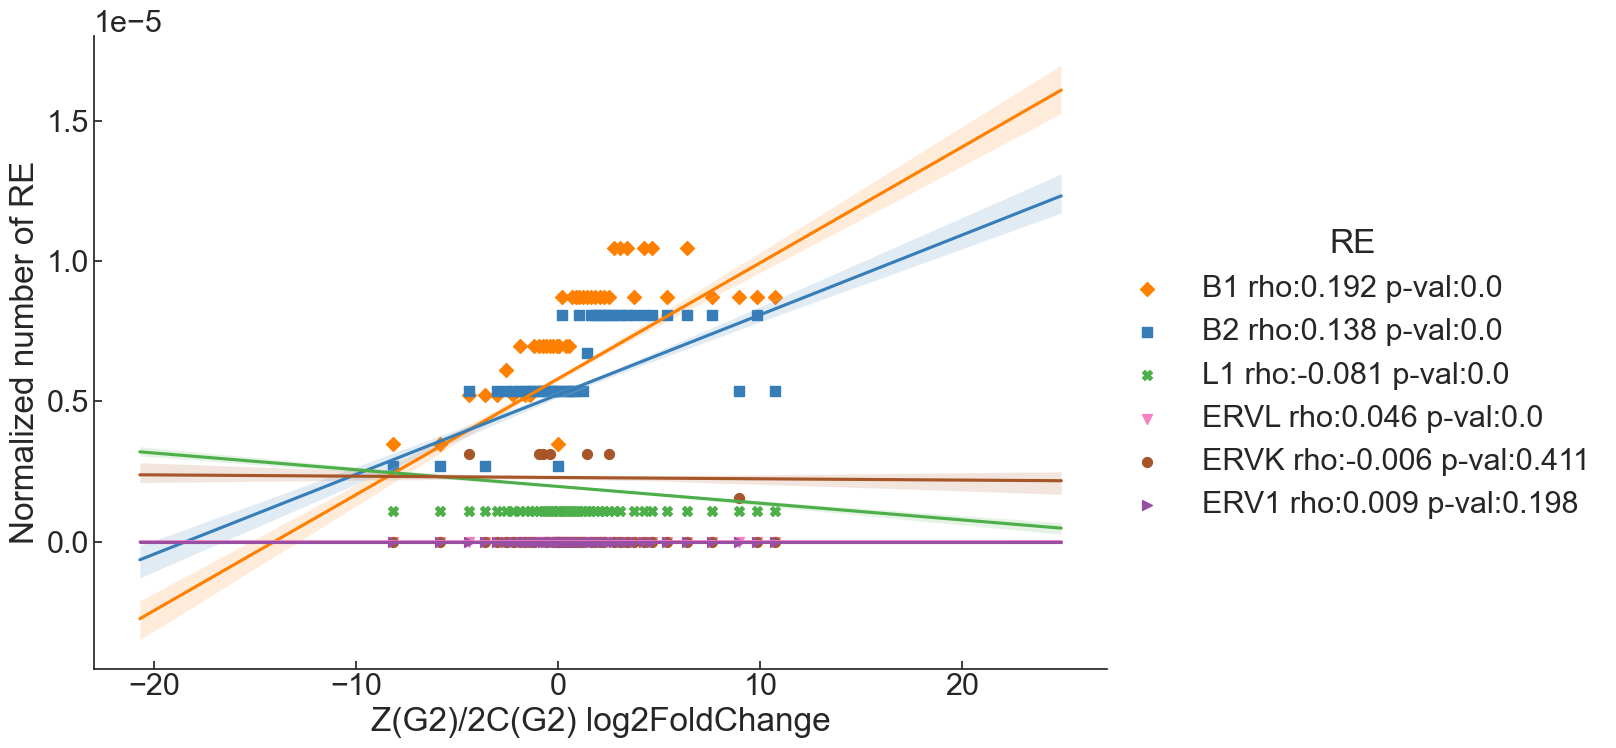

In [18]:
CB_color_cycle = ['#ff7f00', '#377eb8', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

sns.set(font_scale=2, style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
matplotlib.rcParams['font.weight'] = "medium"
matplotlib.rcParams['axes.labelweight'] = 'medium'
matplotlib.rcParams['figure.titleweight'] = 'medium'
matplotlib.rcParams['axes.titleweight'] = 'medium'
matplotlib.rcParams['figure.figsize'] = 8, 6
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

f = plt.figure(constrained_layout=True)


RE_df_Expression["Z(G2)/2C(G2) log2FoldChange"] = RE_df_Expression['G2/2C log2FoldChange']
ax = sns.lmplot(data=RE_df_Expression, x_bins=100, x_estimator=np.median, n_boot=100, robust=True, x="Z(G2)/2C(G2) log2FoldChange", y="Normalized number of RE", hue="RE", height=8, aspect=1.5, markers=["D", "s", "X", "v", "o", ">"], x_ci=None, palette=CB_color_cycle)


plt.savefig("./Panel_B.pdf") 